In [2]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt


sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [3]:
# put current date and time in filename
INPUT_GLOB = "out/*.out"

# get date of newest file in output directory
newest_t = datetime.datetime.fromtimestamp(os.path.getctime(max(glob.iglob(INPUT_GLOB), key=os.path.getctime))).strftime('%Y-%m-%d-%H-%M-%S')

OUTPUT_DIR = "output"

In [4]:
keys_data = []
switch_data = []
switch_logs = []
access_logs = []
sat_info_logs = []

# first read the orchestrator logs
with open("out/gst-orchestrator.out") as f:
    for line in f:
        if "keys_info" in line:
            items = line.split(":")
            keys_data.append((f"{items[0]}:{items[1]}:{items[2]}", items[6].strip()))
            continue
        if "switch_event" in line:
            items = line.split(":")
            gst, sat = items[6].strip().split(",")
            switch_data.append((f"{items[0]}:{items[1]}:{items[2]}", f"switch_{gst}", sat))
            continue
        if "deploy_start_info" in line or "deploy_complete_info" in line or "undeploy_start_info" in line or "undeploy_complete_info" in line:
            items = line.split(":")
            sat = items[6].strip()
            log_type = {
                "deploy_start_info": "deploy_start",
                "deploy_complete_info": "deploy_complete",
                "undeploy_start_info": "undeploy_start",
                "undeploy_complete_info": "undeploy_complete"
            }[items[5].strip()]

            switch_data.append((f"{items[0]}:{items[1]}:{items[2]}", log_type, sat))
            continue
        if "sat_info" in line:
            items = line.split(":")
            t = f"{items[0]}:{items[1]}:{items[2]}"
            gst, sat, delay = items[6].strip().split(",")
            sat_info_logs.append((t, gst, sat, delay))
            continue
        if "_time" in line:
            items = line.split(":")
            t = f"{items[0]}:{items[1]}:{items[2]}"
            fred_available_time,closest_sat_time,replication_time,func_deploy_time = items[5].split("=")[1].strip().split(",")
            switch_logs.append((t, fred_available_time, closest_sat_time, replication_time, func_deploy_time))
            continue

        continue

# now the client log
with open("out/gst-redmond.out") as f:
    for line in f:
        if "request_info" in line:
            items = line.strip().split(" ")
            t = f"{items[0]} {items[1]}"
            op, req_t, host = items[4].split(",")
            access_logs.append((t, op, req_t, host))
            continue
        continue

# now save everything as files
keys_df = pd.DataFrame(keys_data, columns=["time", "num_keys"])
keys_df["time"] = pd.to_datetime(keys_df["time"], format="%Y-%m-%d %H:%M:%S,%f")
keys_df["num_keys"] = keys_df["num_keys"].astype(int)

switch_log_df = pd.DataFrame(switch_data, columns=["time", "log_type", "sat"])
switch_log_df["time"] = pd.to_datetime(switch_log_df["time"], format="%Y-%m-%d %H:%M:%S,%f")

switch_df = pd.DataFrame(switch_logs, columns=["time", "fred_available_time", "closest_sat_time", "replication_time", "func_deploy_time"])
switch_df["time"] = pd.to_datetime(switch_df["time"], format="%Y-%m-%d %H:%M:%S,%f")
switch_df["fred_available_time"] = switch_df["fred_available_time"].astype(float)
switch_df["closest_sat_time"] = switch_df["closest_sat_time"].astype(float)
switch_df["replication_time"] = switch_df["replication_time"].astype(float)
switch_df["func_deploy_time"] = switch_df["func_deploy_time"].astype(float)

sat_info_df = pd.DataFrame(sat_info_logs, columns=["time", "gst", "sat", "delay"])
sat_info_df["time"] = pd.to_datetime(sat_info_df["time"], format="%Y-%m-%d %H:%M:%S,%f")
sat_info_df["delay"] = sat_info_df["delay"].astype(float)

access_df = pd.DataFrame(access_logs, columns=["time", "op", "req_t", "host"])
access_df["time"] = pd.to_datetime(access_df["time"], format="%Y/%m/%d %H:%M:%S.%f")
access_df["req_t"] = access_df["req_t"].astype(float)

# figure out the start time
start_time = min(keys_df["time"].min(), switch_df["time"].min(), access_df["time"].min())
keys_df["time_ms"] = (keys_df["time"] - start_time).astype(int) / 1e6
switch_df["time_ms"] = (switch_df["time"] - start_time).astype(int) / 1e6
access_df["time_ms"] = (access_df["time"] - start_time).astype(int) / 1e6
switch_log_df["time_ms"] = (switch_log_df["time"] - start_time).astype(int) / 1e6
sat_info_df["time_ms"] = (sat_info_df["time"] - start_time).astype(int) / 1e6

In [5]:

keys_df.to_csv(f"{OUTPUT_DIR}/keys-{newest_t}.csv", index=False)
switch_log_df.to_csv(f"{OUTPUT_DIR}/switchlog-{newest_t}.csv", index=False)

switch_df.to_csv(f"{OUTPUT_DIR}/switch-{newest_t}.csv", index=False)
access_df.to_csv(f"{OUTPUT_DIR}/access-{newest_t}.csv", index=False)
sat_info_df.to_csv(f"{OUTPUT_DIR}/satinfo-{newest_t}.csv", index=False)

<Axes: xlabel='time_ms', ylabel='num_keys'>

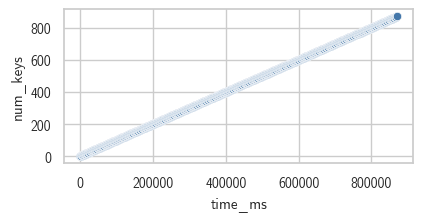

In [6]:
sns.scatterplot(data=keys_df, x="time_ms", y="num_keys")

<Axes: xlabel='time_ms', ylabel='value'>

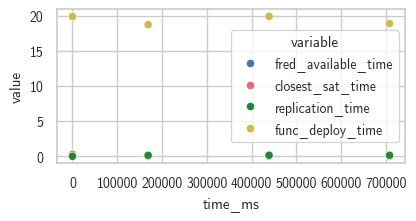

In [7]:
switch_data_for_plot = switch_df.melt(id_vars=["time_ms"], value_vars=["fred_available_time", "closest_sat_time", "replication_time", "func_deploy_time"])
sns.scatterplot(data=switch_data_for_plot, x="time_ms", y="value", hue="variable")

<Axes: xlabel='time_ms', ylabel='req_t'>

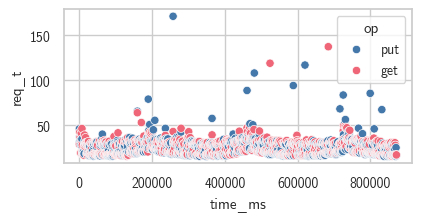

In [8]:
sns.scatterplot(data=access_df, x="time_ms", y="req_t", hue="op")

<Axes: xlabel='time_ms', ylabel='delay'>

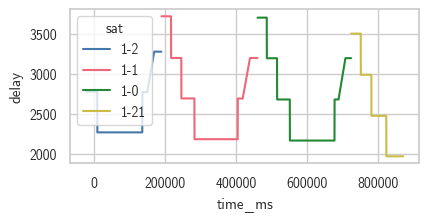

In [9]:
sns.lineplot(data=sat_info_df, x="time_ms", y="delay", hue="sat")

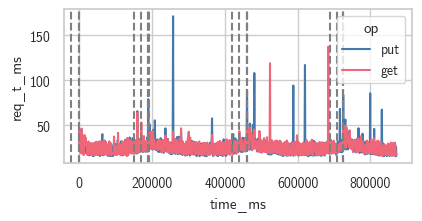

In [10]:
access_df_graph = access_df
access_df_graph["req_t_ms"] = access_df_graph["req_t"]
g = sns.lineplot(data=access_df_graph, x="time_ms", y="req_t_ms", hue="op")

# add vertical lines for switch events
for t in switch_log_df["time_ms"]:
    plt.axvline(t, color="gray", linestyle="--")

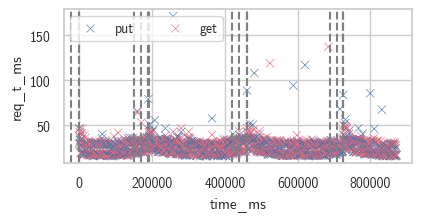

In [11]:
access_df_graph = access_df
access_df_graph["req_t_ms"] = access_df_graph["req_t"]
g = sns.scatterplot(data=access_df_graph, x="time_ms", y="req_t_ms", hue="op", marker="x", alpha=0.9)

# add vertical lines for switch events
for t in switch_log_df["time_ms"]:
    plt.axvline(t, color="gray", linestyle="--")

# g.set(ylim=(0, 40))
g.legend(title=None, loc="upper left", ncols=2)


In [12]:
switch_log_df

,time,log_type,sat,time_ms
0,2024-07-04 07:43:09.141,deploy_start,1-2,-22260.0
1,2024-07-04 07:43:31.419,deploy_complete,1-2,18.0
2,2024-07-04 07:43:31.441,switch_redmond,2.1.celestial,40.0
3,2024-07-04 07:46:01.433,deploy_start,1-1,150032.0
4,2024-07-04 07:46:20.405,deploy_complete,1-1,169004.0
5,2024-07-04 07:46:41.225,undeploy_start,1-2,189824.0
6,2024-07-04 07:46:41.254,switch_redmond,1.1.celestial,189853.0
7,2024-07-04 07:46:42.410,undeploy_complete,1-2,191009.0
8,2024-07-04 07:50:30.413,deploy_start,1-0,419012.0
9,2024-07-04 07:50:50.594,deploy_complete,1-0,439193.0


In [13]:
# figure out the periods where two things where deployed at the same time
# iterate through the switch logs
period_logs = []
event_logs = []
for i, row in switch_log_df.iterrows():
    if i < 3:
        continue
    if row["log_type"] == "deploy_complete":
        period_logs.append([row["time_ms"], None])
    if row["log_type"] == "undeploy_complete":
        period_logs[-1][1] = row["time_ms"]
    if row["log_type"] == "switch_redmond":
        event_logs.append((row["time_ms"], "redmond"))


In [14]:
period_logs

[[169004.0, 191009.0], [439193.0, 461993.0], [708347.0, 726010.0]]

In [15]:
m = 0
for p in period_logs:
    m += p[1] - p[0]
    print(p[1] - p[0])
print(m/len(period_logs))
print(min(access_df["time_ms"]), max(access_df["time_ms"]))
print(max(access_df["time_ms"]) - min(access_df["time_ms"]))
print((m/len(period_logs))/(max(access_df["time_ms"]) - min(access_df["time_ms"])))

22005.0
22800.0
17663.0
20822.666666666668
721.445 871331.216
870609.7710000001
0.023917336285749848


webf NOT subset; don't know how to subset; dropped


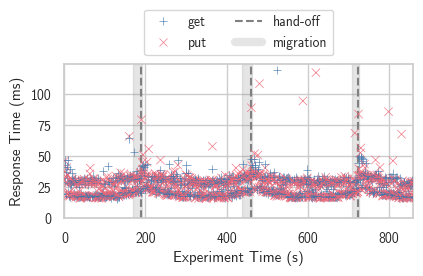

In [16]:
access_df_graph = access_df
access_df_graph["req_t_ms"] = access_df_graph["req_t"]
access_df_graph["time_s"] = access_df_graph["time_ms"] / 1000
g = sns.scatterplot(data=access_df_graph, x="time_s", y="req_t_ms", hue="op", style="op", markers=["x", "+"], alpha=0.9, hue_order=["get", "put"], zorder=10)

# add vertical lines for switch events
for t in event_logs:
    plt.axvline(t[0]/1000, color="gray", linestyle="--")

for t in period_logs:
    plt.axvspan(t[0]/1000, t[1]/1000, alpha=0.2, color="gray")

# g.set(ylim=(0, 40))
# get 99.9th percentile for put and get
put_99 = access_df["req_t"].quantile(0.999)

g.set(xlim=(0, 860), ylim=(0, put_99), ylabel="Response Time (ms)", xlabel="Experiment Time (s)")
g.legend(title=None, loc="upper left", ncols=2)

# add handles for markers to the legend
handles, labels = g.get_legend_handles_labels()
labels.append("hand-off")
labels.append("migration")
handles.append(plt.Line2D([0], [0], linestyle='--', color='gray'))
handles.append(plt.Line2D([0], [0], linestyle='-', color='gray', alpha=0.2, linewidth=6))

g.legend(handles=handles, labels=labels, title=None, loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.4))

plt.savefig("simple-results.pdf", bbox_inches="tight")


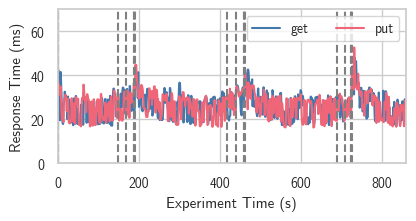

In [17]:
# 5s rolling mean for req_t and req_t_ms
access_df_graph_rolling = access_df_graph[["time", "op", "req_t_ms"]].groupby("op").rolling("3s", on="time").median().reset_index()
access_df_graph_rolling["time_s"] = (access_df_graph_rolling["time"] - start_time).astype(int) / 1e9

g = sns.lineplot(data=access_df_graph_rolling, x="time_s", y="req_t_ms", hue="op")

# add vertical lines for switch events
for t in switch_log_df["time_ms"]:
    plt.axvline(t/1000, color="gray", linestyle="--")

g.set(ylim=(0, 70), xlim=(0, 860), ylabel="Response Time (ms)", xlabel="Experiment Time (s)")
g.legend(title=None, loc="upper right", ncols=2)
# plt.savefig("simple-results.pdf", bbox_inches="tight")